# Testing InceptionV3 network (variation 1)

In this notebook I use the data explored and processed in notebooks 1-3 to see how well the pretrained InceptionV3 model works as a classifier.

In [1]:
import os
import time
import pickle

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import metrics

#TODO implement this function
from cars_utils import time_save_model, plot_metrics

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### BASIC  IMAGE, AND BATCH SETUP

In [2]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 299, 299

WORKING_DIR = os.getcwd()
BASE = os.path.join(WORKING_DIR, 'data', 'cars_dataset', 'keras')

SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'InceptionV3')

### Settings for full training
TRAIN_DATA_DIR = os.path.join(BASE, 'train')
VALIDATION_DATA_DIR = os.path.join(BASE, 'validation')
NB_CLASSES = 196
NB_TRAIN_SAMPLES = 11329
NB_VALIDATION_SAMPLES = 2428
BATCH_SIZE = 32

### Settings for fast checking
# SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_test')
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast', 'validation')
# NB_CLASSES = 196
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

### Settings for faster checking
# SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_v2_test')
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast_v2', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast_v2', 'validation')
# NB_CLASSES = 6
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [3]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=INPUT_SHAPE
)

In [4]:
pred_layer_config = {
    'activation': 'softmax',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
                           'config': {
                               'distribution': 'uniform',
                               'mode': 'fan_avg',
                               'scale': 1.0,
                               'seed': 8}
                          },
    'kernel_regularizer': None,
    'name': 'predictions',
    'trainable': True,
    'units': NB_CLASSES,
    'use_bias': True}

model = Sequential()
model.add(conv_base)
model.add(Dense(**pred_layer_config))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 190
This is the number of trainable weights after freezing the conv base: 2


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
predictions (Dense)          (None, 196)               401604    
Total params: 22,204,388
Trainable params: 401,604
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=7)

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=13)

Found 11329 images belonging to 196 classes.
Found 2428 images belonging to 196 classes.


Define custom metrics to measure

In [9]:
def top_3_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

In [10]:
from keras import optimizers

optimizer = optimizers.RMSprop(lr=0.0001, rho=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_3_acc])

In [12]:
EPOCHS = 30
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/30
354/354 [==============================] - 292s 826ms/step - loss: 5.2860 - categorical_accuracy: 0.0086 - top_3_acc: 0.0267 - val_loss: 5.1697 - val_categorical_accuracy: 0.0154 - val_top_3_acc: 0.0392
Epoch 2/30
354/354 [==============================] - 292s 824ms/step - loss: 5.0953 - categorical_accuracy: 0.0277 - top_3_acc: 0.0705 - val_loss: 4.9982 - val_categorical_accuracy: 0.0338 - val_top_3_acc: 0.0896
Epoch 3/30
354/354 [==============================] - 290s 820ms/step - loss: 4.9477 - categorical_accuracy: 0.0510 - top_3_acc: 0.1092 - val_loss: 4.8533 - val_categorical_accuracy: 0.0575 - val_top_3_acc: 0.1383
Epoch 4/30
354/354 [==============================] - 288s 814ms/step - loss: 4.8013 - categorical_accuracy: 0.0703 - top_3_acc: 0.1505 - val_loss: 4.7378 - val_categorical_accuracy: 0.0688 - val_top_3_acc: 0.1517
Epoch 5/30
354/354 [==============================] - 292s 825ms/step - loss: 4.6816 - categorical_accuracy: 0.0916 - top_3_acc: 0.1892 - val_lo

In [13]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                '1_InceptionV3_1_0_30',
                SAVE_DIR)

traing took: 143.0 minutes


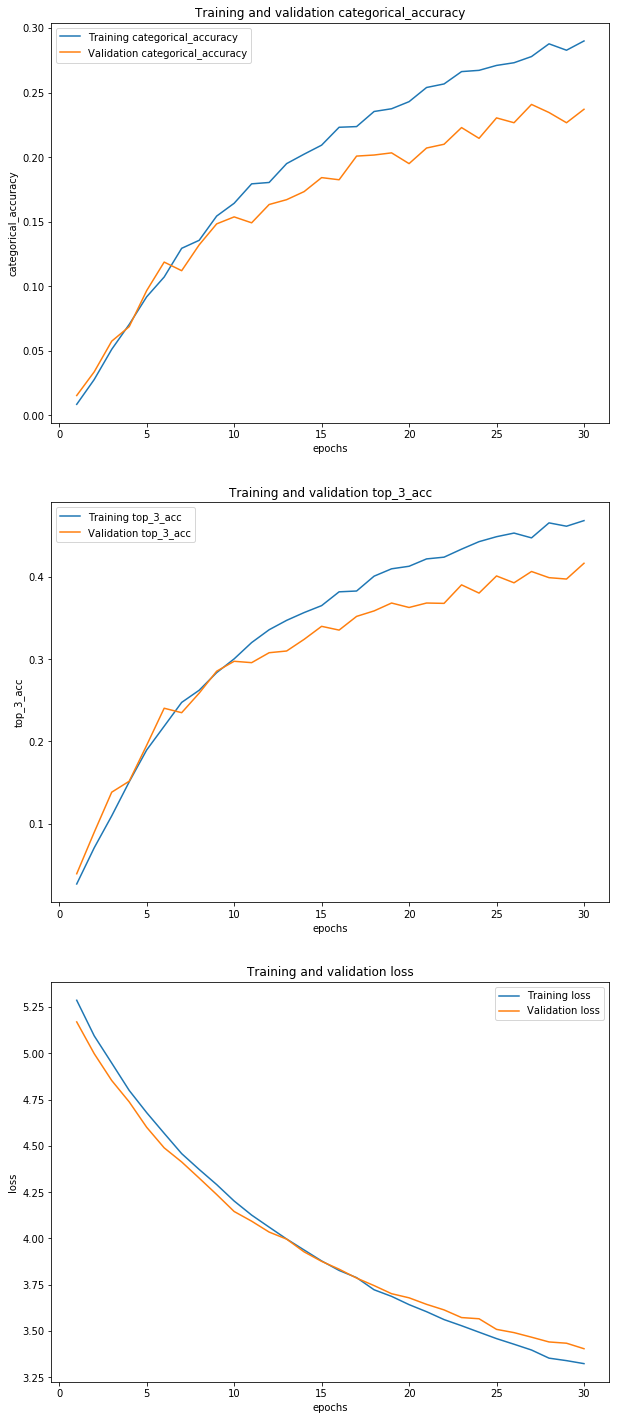

In [15]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'loss']
show = plot_metrics(summary.history, key_list)